In [29]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import os

# --------------------------
# Q-Network definition
# --------------------------
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256, num_layers=2):
        """
        Constructs an MLP to approximate Q(x) with num_layers (2 or 3 layers recommended).
        The final output dimension equals the number of discrete actions.
        """
        super(QNetwork, self).__init__()
        layers = []
        # first layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        # add extra hidden layers if needed
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        # output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.model = nn.Sequential(*layers)
        self.init_weights()
        
    def init_weights(self):
        # Initialize all linear layers uniformly between -0.001 and 0.001
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, a=-0.001, b=0.001)
                if m.bias is not None:
                    nn.init.uniform_(m.bias, a=-0.001, b=0.001)
                    
    def forward(self, x):
        return self.model(x)

# --------------------------
# Replay Buffer
# --------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

# --------------------------
# Preprocess State (Normalization)
# --------------------------
def preprocess_state(env, state):
    """
    For environments such as Assault-ram-v5 where observations are uint8,
    convert to float and normalize by dividing by 255.
    """
    if isinstance(state, np.ndarray) and state.dtype == np.uint8:
        return state.astype(np.float32) / 255.0
    else:
        return np.array(state, dtype=np.float32)

# --------------------------
# Single-transition update (no replay)
# --------------------------
def update_q_network(q_network, optimizer, state, action, reward, next_state, done, gamma, epsilon, algorithm, device):
    q_network.train()
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    q_values = q_network(state_tensor)
    q_value = q_values[0, action].unsqueeze(0)
    
    # Compute target value
    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
    with torch.no_grad():
        next_q_values = q_network(next_state_tensor)
    
    if done:
        target = reward
    else:
        if algorithm == 'q_learning':
            target = reward + gamma * next_q_values.max().item()
        elif algorithm == 'expected_sarsa':
            num_actions = next_q_values.shape[1]
            best_action = next_q_values.argmax().item()
            expected_value = 0.0
            for a in range(num_actions):
                # Under ε-greedy: best action gets (1-ε+ε/num_actions), others get ε/num_actions
                if a == best_action:
                    prob = 1 - epsilon + epsilon / num_actions
                else:
                    prob = epsilon / num_actions
                expected_value += prob * next_q_values[0, a].item()
            target = reward + gamma * expected_value
        else:
            raise ValueError("Unknown algorithm type.")
    
    target_tensor = torch.FloatTensor([target]).to(device)
    loss = nn.MSELoss()(q_value, target_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# --------------------------
# Batch update (with replay)
# --------------------------
def update_q_network_batch(q_network, optimizer, states, actions, rewards, next_states, dones, gamma, epsilon, algorithm, device):
    q_network.train()
    states_tensor = torch.FloatTensor(states).to(device)
    actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards_tensor = torch.FloatTensor(rewards).to(device)
    next_states_tensor = torch.FloatTensor(next_states).to(device)
    dones_tensor = torch.FloatTensor(dones).to(device)
    
    q_values = q_network(states_tensor)
    q_value = q_values.gather(1, actions_tensor).squeeze(1)
    
    with torch.no_grad():
        next_q_values = q_network(next_states_tensor)
    
    if algorithm == 'q_learning':
        target = rewards_tensor + gamma * (1 - dones_tensor) * next_q_values.max(1)[0]
    elif algorithm == 'expected_sarsa':
        num_actions = next_q_values.shape[1]
        best_actions = next_q_values.argmax(dim=1)
        # Build probability distribution for each next state
        probs = torch.ones_like(next_q_values) * (epsilon / num_actions)
        for i in range(len(best_actions)):
            probs[i, best_actions[i]] = 1 - epsilon + epsilon / num_actions
        expected_q = (next_q_values * probs).sum(dim=1)
        target = rewards_tensor + gamma * (1 - dones_tensor) * expected_q
    else:
        raise ValueError("Unknown algorithm type.")
    
    loss = nn.MSELoss()(q_value, target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# --------------------------
# Run one episode (either online update or with replay)
# --------------------------
def train_episode(env, q_network, optimizer, gamma, epsilon, algorithm, replay_buffer=None, batch_size=64, device='cuda'):
    state = env.reset()
    state = preprocess_state(env, state)
    total_reward = 0
    done = False
    while not done:
        # ε–greedy action selection using the current Q–network
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = q_network(state_tensor)
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = q_values.argmax().item()
            
        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_state(env, next_state)
        total_reward += reward
        
        # Update: if not using replay, perform update immediately; otherwise add to buffer and update from batch
        if replay_buffer is None:
            update_q_network(q_network, optimizer, state, action, reward, next_state, done, gamma, epsilon, algorithm, device)
        else:
            replay_buffer.add(state, action, reward, next_state, done)
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                update_q_network_batch(q_network, optimizer, states, actions, rewards, next_states, dones, gamma, epsilon, algorithm, device)
        
        state = next_state
    return total_reward

# --------------------------
# Run one experiment (one seed) for given configuration
# --------------------------
def run_experiment(env_name, algorithm, use_replay, epsilon, step_size, num_episodes=1000, seed=0, num_layers=2, hidden_dim=256, gamma=0.99, batch_size=64, device='cuda'):
    # Create environment and set seeds for reproducibility
    env = gym.make(env_name)
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    
    # Determine input dimension from observation space
    if hasattr(env.observation_space, 'shape'):
        input_dim = env.observation_space.shape[0]
    else:
        raise ValueError("Unknown observation space format.")
    output_dim = env.action_space.n
    
    # Initialize Q-network and optimizer (using SGD with the given step size)
    q_network = QNetwork(input_dim, output_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = optim.SGD(q_network.parameters(), lr=step_size)
    
    # Optionally use a replay buffer (capacity 1e6)
    replay_buffer = ReplayBuffer(capacity=int(1e6)) if use_replay else None
    
    episode_rewards = []
    import tqdm
    # for ep in range(num_episodes):
    for ep in tqdm.tqdm(range(num_episodes)):
        ep_reward = train_episode(env, q_network, optimizer, gamma, epsilon, algorithm, replay_buffer, batch_size, device)
        episode_rewards.append(ep_reward)
    env.close()
    return episode_rewards

In [30]:
# Setup parameters and initialize results dictionary
num_seeds = 10
num_episodes = 1000
epsilons = [0.1, 0.2, 0.3]
step_sizes = [1/4, 1/8, 0.0625]  # 1/4, 1/8, 1/16
# step_sizes = [0.01, 0.001, 0.0001]  # 1/100, 1/1000, 1/10000
algorithms = ['q_learning', 'expected_sarsa']
replay_settings = [False, True]
env_names = ["Acrobot-v1", "ALE/Assault-ram-v5"]
# device = torch.device("cuda")
device = torch.device("cpu")
print("Device:", device)
gamma = 0.99
batch_size = 64
num_layers = 2  # or 3 as desired

# Dictionary to hold all results:
results = {}  # structure: results[env][use_replay][epsilon][step_size][algorithm] = np.array (seeds x episodes)

# Create directory to save plots
os.makedirs("plots", exist_ok=True)

print("Setup complete.")

Device: cpu
Setup complete.


In [31]:
def run_experiments(env_name, use_replay, eps, step, results, num_seeds, num_episodes, algorithms, num_layers, gamma, batch_size, device):
  results[env_name][use_replay].setdefault(eps, {})
  results[env_name][use_replay][eps].setdefault(step, {})
  # Compute and store results for all algorithms first
  for alg in algorithms:
      print(f"Acrobot-v1 | Replay: {use_replay} | ε: {eps} | step size: {step} | Alg: {alg}")
      all_rewards = []
      for seed in range(num_seeds):
          ep_rewards = run_experiment(
              env_name, alg, use_replay, eps, step, num_episodes=num_episodes,
              seed=seed, num_layers=num_layers, gamma=gamma, batch_size=batch_size, device=device
          )
          all_rewards.append(ep_rewards)
      results[env_name][use_replay][eps][step][alg] = np.array(all_rewards)
  
  plt.figure()
  episodes = np.arange(1, num_episodes + 1)
  for a, color, ls in zip(algorithms, ['green', 'red'], ['-', '--']):
      data = results[env_name][use_replay][eps][step][a]
      mean_reward = data.mean(axis=0)
      std_reward = data.std(axis=0)
      plt.plot(episodes, mean_reward, color=color, linestyle=ls, label=f"{a}")
      plt.fill_between(episodes, mean_reward - std_reward, mean_reward + std_reward,
                        color=color, alpha=0.2)
  plt.xlabel("Episode")
  plt.ylabel("Total Reward")
  replay_text = "Replay" if use_replay else "No Replay"
  plt.title(f"{env_name} | {replay_text} | ε={eps} | step size={step}")
  plt.legend()
  plt.tight_layout()
  plot_filename = f"plots/{env_name}_{'replay' if use_replay else 'noreplay'}_eps{eps}_step{step}.png"
  plt.savefig(plot_filename)
  plt.show()
  plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: False | ε: 0.1 | step size: 0.01 | Alg: q_learning


  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: False | ε: 0.1 | step size: 0.01 | Alg: expected_sarsa


100%|██████████| 1000/1000 [09:46<00:00,  1.70it/s]


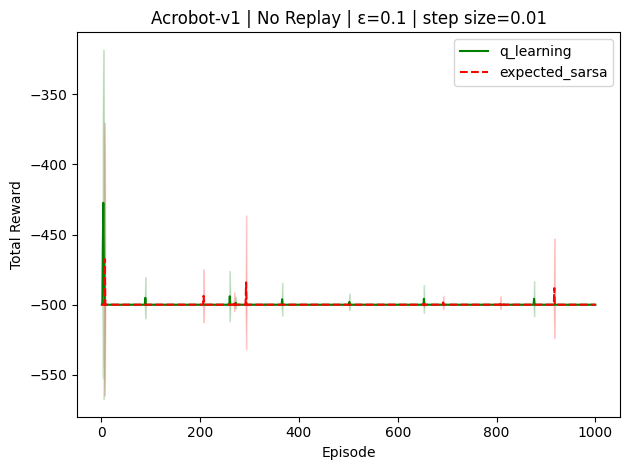

  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: False | ε: 0.2 | step size: 0.001 | Alg: q_learning


  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: False | ε: 0.2 | step size: 0.001 | Alg: expected_sarsa


100%|██████████| 1000/1000 [09:43<00:00,  1.71it/s]


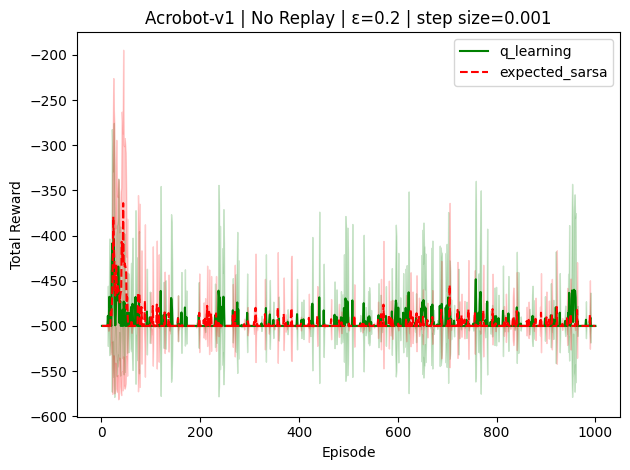

In [30]:
env_name = "Acrobot-v1"
results.setdefault(env_name, {})          # Ensure environment key exists
use_replay = False                        # No replay for this block
results[env_name].setdefault(use_replay, {})

eps = epsilons[0]
run_experiments(env_name, use_replay, eps, step_sizes[0], results, num_seeds, num_episodes, algorithms, num_layers, gamma, batch_size, device)
eps = epsilons[1]
run_experiments(env_name, use_replay, eps, step_sizes[1], results, num_seeds, num_episodes, algorithms, num_layers, gamma, batch_size, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: False | ε: 0.3 | step size: 0.0001 | Alg: q_learning


  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: False | ε: 0.3 | step size: 0.0001 | Alg: expected_sarsa


100%|██████████| 1000/1000 [08:57<00:00,  1.86it/s]


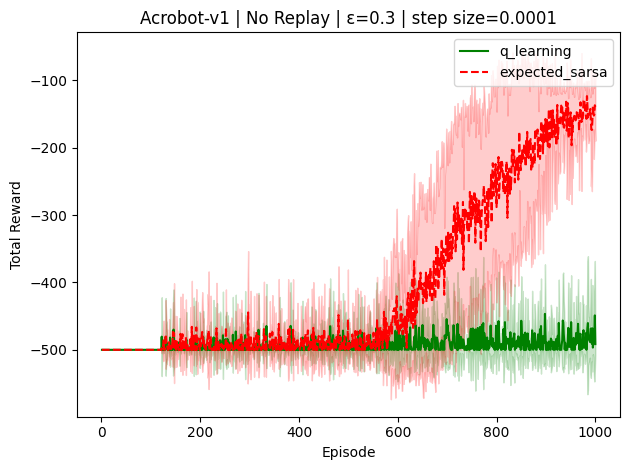

In [31]:
eps = epsilons[2]
run_experiments(env_name, use_replay, eps, step_sizes[2], results, num_seeds, num_episodes, algorithms, num_layers, gamma, batch_size, device)

Acrobot-v1 | Replay: True | ε: 0.1 | step size: 0.01 | Alg: q_learning


/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: True | ε: 0.1 | step size: 0.01 | Alg: expected_sarsa


100%|██████████| 1000/1000 [06:03<00:00,  2.75it/s]
/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


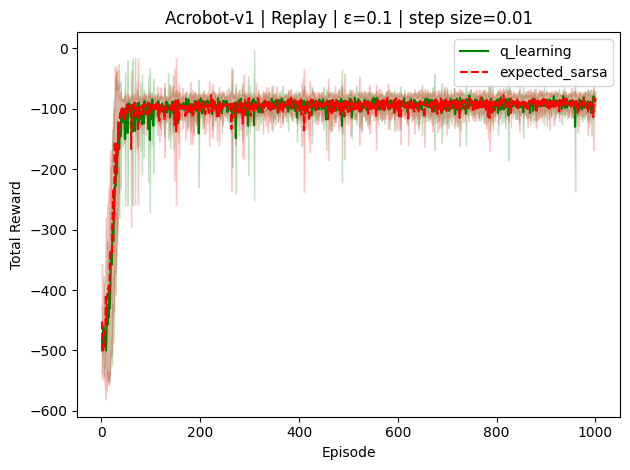

In [4]:
env_name = "Acrobot-v1"
results.setdefault(env_name, {})          # Ensure environment key exists
use_replay = True
results[env_name].setdefault(use_replay, {})

eps = epsilons[0]
run_experiments(env_name, use_replay, eps, step_sizes[0], results, num_seeds, num_episodes, algorithms, num_layers, gamma, batch_size, device)

Acrobot-v1 | Replay: True | ε: 0.2 | step size: 0.001 | Alg: q_learning


/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: True | ε: 0.2 | step size: 0.001 | Alg: expected_sarsa


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]
/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


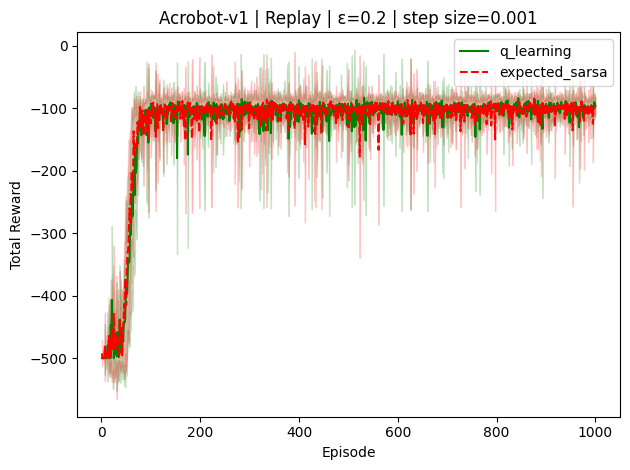

  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: True | ε: 0.3 | step size: 0.0001 | Alg: q_learning


  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: True | ε: 0.3 | step size: 0.0001 | Alg: expected_sarsa


100%|██████████| 1000/1000 [11:15<00:00,  1.48it/s]


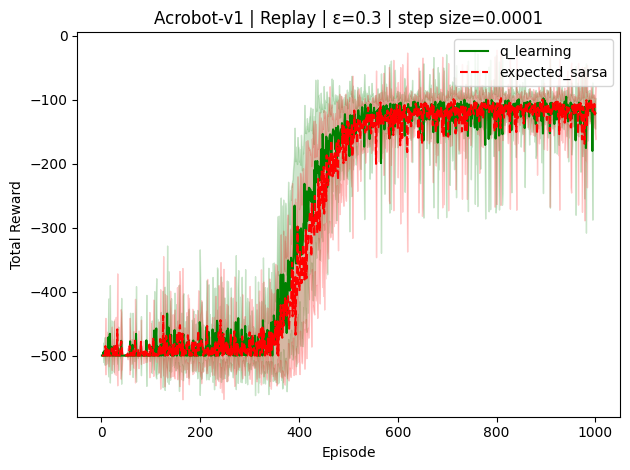

In [5]:
env_name = "Acrobot-v1"
results.setdefault(env_name, {})          # Ensure environment key exists
use_replay = True
results[env_name].setdefault(use_replay, {})
eps = epsilons[1]
run_experiments(env_name, use_replay, eps, step_sizes[1], results, num_seeds, num_episodes, algorithms, num_layers, gamma, batch_size, device)
eps = epsilons[2]
run_experiments(env_name, use_replay, eps, step_sizes[2], results, num_seeds, num_episodes, algorithms, num_layers, gamma, batch_size, device)

Acrobot-v1 | Replay: False | ε: 0.1 | step size: 0.01 | Alg: q_learning


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: False | ε: 0.1 | step size: 0.01 | Alg: expected_sarsa


100%|██████████| 1000/1000 [15:11<00:00,  1.10it/s]
/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


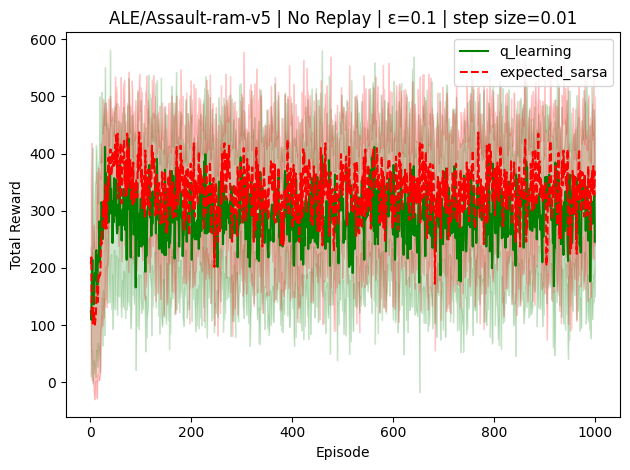

  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: False | ε: 0.2 | step size: 0.001 | Alg: q_learning


  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: False | ε: 0.2 | step size: 0.001 | Alg: expected_sarsa


 69%|██████▊   | 687/1000 [11:21<04:28,  1.17it/s]

KeyboardInterrupt: 

In [ ]:
env_name = "ALE/Assault-ram-v5"
results.setdefault(env_name, {})          # Initialize for Assault-ram-v5
use_replay = False                         # No replay setting for this block
results[env_name].setdefault(use_replay, {})

eps = epsilons[0]
run_experiments(env_name, use_replay, eps, step_sizes[0], results, num_seeds, num_episodes, algorithms, num_layers, gamma, batch_size, device)



Acrobot-v1 | Replay: False | ε: 0.2 | step size: 0.001 | Alg: q_learning


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: False | ε: 0.2 | step size: 0.001 | Alg: expected_sarsa


100%|██████████| 1000/1000 [16:28<00:00,  1.01it/s]
/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


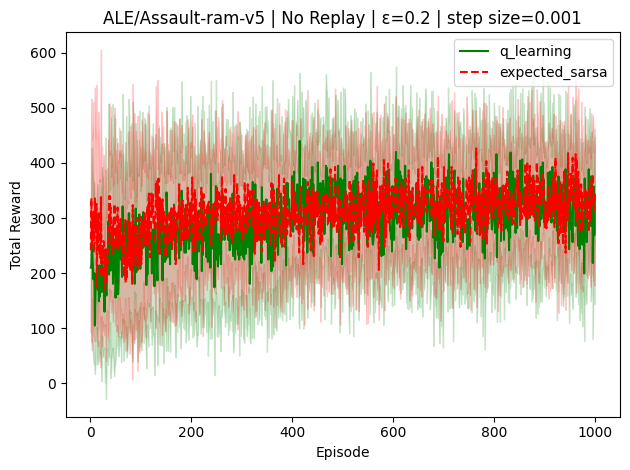

  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: False | ε: 0.3 | step size: 0.0001 | Alg: q_learning


  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: False | ε: 0.3 | step size: 0.0001 | Alg: expected_sarsa


 12%|█▏        | 120/1000 [07:58<1:35:19,  6.50s/it]

In [ ]:
env_name = "ALE/Assault-ram-v5"
results.setdefault(env_name, {})          # Initialize for Assault-ram-v5
use_replay = False                         # No replay setting for this block
results[env_name].setdefault(use_replay, {})
eps = epsilons[1]
run_experiments(env_name, use_replay, eps, step_sizes[1], results, num_seeds, num_episodes, algorithms, num_layers, gamma, batch_size, device)


Acrobot-v1 | Replay: False | ε: 0.3 | step size: 0.001 | Alg: q_learning


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
  0%|          | 0/1000 [00:00<?, ?it/s]

Acrobot-v1 | Replay: False | ε: 0.3 | step size: 0.001 | Alg: expected_sarsa


100%|██████████| 1000/1000 [21:59<00:00,  1.32s/it]
/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


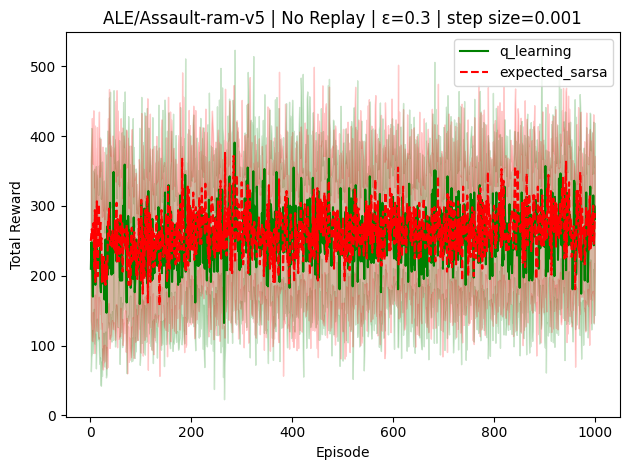

In [4]:
env_name = "ALE/Assault-ram-v5"
results.setdefault(env_name, {})          # Initialize for Assault-ram-v5
use_replay = False                         # No replay setting for this block
results[env_name].setdefault(use_replay, {})
eps = epsilons[2]
run_experiments(env_name, use_replay, eps, step_sizes[1], results, num_seeds, num_episodes, algorithms, num_layers, gamma, batch_size, device)


In [32]:
env_name = "ALE/Assault-ram-v5"
use_replay = True
results.setdefault(env_name, {})          # Ensure environment key exists
results[env_name].setdefault(use_replay, {})

eps = epsilons[0]
run_experiments(env_name, use_replay, eps, step_sizes[0], results, num_seeds, num_episodes, algorithms, num_layers, gamma, batch_size, device)
eps = epsilons[1]
run_experiments(env_name, use_replay, eps, step_sizes[1], results, num_seeds, num_episodes, algorithms, num_layers, gamma, batch_size, device)

Acrobot-v1 | Replay: True | ε: 0.1 | step size: 0.25 | Alg: q_learning


 31%|███▏      | 313/1000 [33:28<1:13:28,  6.42s/it]


KeyboardInterrupt: 

In [ ]:
eps = epsilons[2]
run_experiments(env_name, use_replay, eps, step_sizes[2], results, num_seeds, num_episodes, algorithms, num_layers, gamma, batch_size, device)

### Q2 **Policy Gradient Theorem Derivation**

We start with the policy gradient theorem:  
$$
\nabla J(\pi) = \mathbb{E}_{s \sim d^\pi,\, a \sim \pi} \left[ \nabla \log \pi(a|s) \, Q^\pi(s,a) \right]
$$  
where \( d^\pi(s) \) is the steady state distribution of states under the policy \( \pi \).

Given the softmax parameterization of the policy:  
$$
\pi(a|s) = \frac{\exp(z(s,a))}{\sum_{b \in A} \exp(z(s,b))}
$$

The gradient of the log-policy with respect to \( z(s,a) \) is:  
$$
\nabla_{z(s,a)} \log \pi(a|s) = 1 - \pi(a|s)
$$  
and for any \( b \ne a \):  
$$
\nabla_{z(s,a)} \log \pi(b|s) = -\pi(a|s)
$$

Substituting these into the policy gradient theorem, we have:  
$$
\frac{\partial J(\pi)}{\partial z(s,a)} = d^\pi(s)\pi(a|s) \left[ Q^\pi(s,a) - \sum_{b\in A} \pi(b|s)\, Q^\pi(s,b) \right]
$$

Recognizing that the state-value function is defined as:  
$$
V^\pi(s) = \sum_{b \in A} \pi(b|s)\, Q^\pi(s,b)
$$

We can rewrite the expression as:  
$$
\frac{\partial J(\pi)}{\partial z(s,a)} = d^\pi(s)\pi(a|s)\left[ Q^\pi(s,a) - V^\pi(s) \right]
$$

Defining the advantage function as:  
$$
A^\pi(s,a) = Q^\pi(s,a) - V^\pi(s)
$$

We obtain the final result:  
$$
\nabla_z J(\pi) = \frac{\partial J(\pi)}{\partial z(s,a)} = d^\pi(s)\pi(a|s) A^\pi(s,a)
$$

In [ ]:
# Q3
# --------------------------
# Neural Network for Policy (z(s))
# --------------------------
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256, num_layers=2):
        super(PolicyNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        # Output: one logit per discrete action
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.model = nn.Sequential(*layers)
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, a=-0.001, b=0.001)
                if m.bias is not None:
                    nn.init.uniform_(m.bias, a=-0.001, b=0.001)
    
    def forward(self, x):
        return self.model(x)

# --------------------------
# Neural Network for Value (for Actor-Critic)
# --------------------------
class ValueNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=2):
        super(ValueNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        # Output: scalar value estimate
        layers.append(nn.Linear(hidden_dim, 1))
        self.model = nn.Sequential(*layers)
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, a=-0.001, b=0.001)
                if m.bias is not None:
                    nn.init.uniform_(m.bias, a=-0.001, b=0.001)
    
    def forward(self, x):
        return self.model(x)

# --------------------------
# Helper: Select action using Boltzmann Policy
# --------------------------
def select_action(policy_net, state, temperature, env, device, training=True):
    if training:
        policy_net.train()  # ensure network is in training mode
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        logits = policy_net(state_tensor).squeeze(0)
    else:
        policy_net.eval()
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = policy_net(state_tensor).squeeze(0)
    scaled_logits = logits / temperature
    probs = torch.softmax(scaled_logits, dim=0)
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

# --------------------------
# REINFORCE: Run one episode (Monte Carlo updates)
# --------------------------
def run_episode_reinforce(env, policy_net, optimizer, gamma, temp_config, episode_idx, num_episodes, device):
    """
    temp_config: dict with keys "type" (either "fixed" or "decreasing"),
                 and for fixed: "T_fixed", for decreasing: "T_initial", "T_final"
    """
    state = env.reset()
    state = preprocess_state(env, state)
    log_probs = []
    rewards = []
    total_reward = 0
    done = False

    while not done:
        # Determine temperature based on configuration
        if temp_config["type"] == "fixed":
            temperature = temp_config["T_fixed"]
        elif temp_config["type"] == "decreasing":
            # Linear decrease from T_initial to T_final
            temperature = temp_config["T_initial"] - (temp_config["T_initial"] - temp_config["T_final"]) * (episode_idx / num_episodes)
        else:
            raise ValueError("Unknown temperature configuration type.")
        
        action, log_prob = select_action(policy_net, state, temperature, env, device)
        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_state(env, next_state)
        
        log_probs.append(log_prob)
        rewards.append(reward)
        total_reward += reward
        state = next_state

    # Compute returns (discounted sum of rewards) from the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.FloatTensor(returns).to(device)
    
    # Normalize returns (optional but often helps)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    
    # Compute policy loss
    policy_loss = 0
    for log_prob, G in zip(log_probs, returns):
        policy_loss += -log_prob * G
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()
    
    return total_reward

# --------------------------
# Actor-Critic: Run one episode with one-step updates
# --------------------------
def run_episode_actor_critic(env, policy_net, value_net, optimizer_policy, optimizer_value, gamma, temp_config, episode_idx, num_episodes, device):
    state = env.reset()
    state = preprocess_state(env, state)
    total_reward = 0
    done = False

    while not done:
        # Determine temperature
        if temp_config["type"] == "fixed":
            temperature = temp_config["T_fixed"]
        elif temp_config["type"] == "decreasing":
            temperature = temp_config["T_initial"] - (temp_config["T_initial"] - temp_config["T_final"]) * (episode_idx / num_episodes)
        else:
            raise ValueError("Unknown temperature configuration type.")
        
        # Compute state value
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        value = value_net(state_tensor)
        
        # Select action using policy network
        action, log_prob = select_action(policy_net, state, temperature, env, device)
        
        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_state(env, next_state)
        total_reward += reward
        
        # Compute TD target and TD error (δ)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        with torch.no_grad():
            next_value = value_net(next_state_tensor)
        target = reward + (gamma * next_value if not done else 0)
        delta = target - value
        
        # Actor loss: policy gradient weighted by TD error (treated as advantage)
        actor_loss = -log_prob * delta.detach()
        # Critic loss: Mean Squared Error
        critic_loss = delta.pow(2)
        
        optimizer_policy.zero_grad()
        optimizer_value.zero_grad()
        (actor_loss + critic_loss).backward()
        optimizer_policy.step()
        optimizer_value.step()
        
        state = next_state
        
    return total_reward

# --------------------------
# Run one experiment (one seed) for REINFORCE
# --------------------------
def run_experiment_reinforce(env_name, temp_config, num_episodes, gamma, lr_policy, seed, num_layers=2, hidden_dim=256, device='cuda'):
    env = gym.make(env_name)
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    
    # Get state and action dimensions
    if hasattr(env.observation_space, 'shape'):
        input_dim = env.observation_space.shape[0]
    else:
        raise ValueError("Unknown observation space format.")
    output_dim = env.action_space.n
    
    policy_net = PolicyNetwork(input_dim, output_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = optim.Adam(policy_net.parameters(), lr=lr_policy)
    
    rewards_per_episode = []
    for ep in range(num_episodes):
        ep_reward = run_episode_reinforce(env, policy_net, optimizer, gamma, temp_config, ep, num_episodes, device)
        rewards_per_episode.append(ep_reward)
    env.close()
    return rewards_per_episode

# --------------------------
# Run one experiment (one seed) for Actor-Critic
# --------------------------
def run_experiment_actor_critic(env_name, temp_config, num_episodes, gamma, lr_policy, lr_value, seed, num_layers=2, hidden_dim=256, device='cuda'):
    env = gym.make(env_name)
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    
    # Get state and action dimensions
    if hasattr(env.observation_space, 'shape'):
        input_dim = env.observation_space.shape[0]
    else:
        raise ValueError("Unknown observation space format.")
    output_dim = env.action_space.n
    
    policy_net = PolicyNetwork(input_dim, output_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    value_net = ValueNetwork(input_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    
    optimizer_policy = optim.Adam(policy_net.parameters(), lr=lr_policy)
    optimizer_value = optim.Adam(value_net.parameters(), lr=lr_value)
    
    rewards_per_episode = []
    for ep in range(num_episodes):
        ep_reward = run_episode_actor_critic(env, policy_net, value_net, optimizer_policy, optimizer_value,
                                             gamma, temp_config, ep, num_episodes, device)
        rewards_per_episode.append(ep_reward)
    env.close()
    return rewards_per_episode

In [3]:
def run_experiment_env(env_name, temp_configs, num_episodes, gamma, lr_policy, lr_value, num_seeds, num_layers, hidden_dim, device, results):
    results[env_name] = {}
    for temp_key, temp_config in temp_configs.items():
        results[env_name][temp_key] = {"reinforce": None, "actor_critic": None}
        all_rewards_reinforce = []
        all_rewards_actor_critic = []
        print(f"Running {env_name} | Temperature config: {temp_key}")
        for seed in range(num_seeds):
            # REINFORCE experiment
            ep_rewards_reinforce = run_experiment_reinforce(env_name, temp_config, num_episodes, gamma,
                                                            lr_policy, seed, num_layers, hidden_dim, device)
            all_rewards_reinforce.append(ep_rewards_reinforce)
            # Actor-Critic experiment
            ep_rewards_actor_critic = run_experiment_actor_critic(env_name, temp_config, num_episodes, gamma,
                                                                    lr_policy, lr_value, seed, num_layers, hidden_dim, device)
            all_rewards_actor_critic.append(ep_rewards_actor_critic)
        results[env_name][temp_key]["reinforce"] = np.array(all_rewards_reinforce)
        results[env_name][temp_key]["actor_critic"] = np.array(all_rewards_actor_critic)
        
        # Plot training curves for this temperature configuration on the given environment
        episodes = np.arange(1, num_episodes+1)
        plt.figure()
        # REINFORCE: green, solid
        data_reinforce = results[env_name][temp_key]["reinforce"]
        mean_reinforce = data_reinforce.mean(axis=0)
        std_reinforce = data_reinforce.std(axis=0)
        plt.plot(episodes, mean_reinforce, color='green', linestyle='-', label="REINFORCE")
        plt.fill_between(episodes, mean_reinforce - std_reinforce, mean_reinforce + std_reinforce,
                            color='green', alpha=0.2)
        # Actor-Critic: red, dashed
        data_ac = results[env_name][temp_key]["actor_critic"]
        mean_ac = data_ac.mean(axis=0)
        std_ac = data_ac.std(axis=0)
        plt.plot(episodes, mean_ac, color='red', linestyle='--', label="Actor-Critic")
        plt.fill_between(episodes, mean_ac - std_ac, mean_ac + std_ac,
                            color='red', alpha=0.2)
        
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title(f"{env_name} | Temperature: {temp_key}")
        plt.legend()
        plt.tight_layout()
        plot_filename = f"plots_policy/{env_name}_{temp_key}.png"
        os.makedirs(os.path.dirname(plot_filename), exist_ok=True)
        plt.show()
        plt.savefig(plot_filename)
        plt.close()
    return results

In [4]:
# Experiment settings
num_seeds = 10          
num_episodes = 1000      
gamma = 0.99
lr_policy = 1e-3         # Learning rate for policy networks (tweak as desired)
lr_value = 1e-3          # Learning rate for value network in Actor-Critic
num_layers = 2
hidden_dim = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Temperature configurations: fixed and decreasing
temp_configs = {
    "fixed": {"type": "fixed", "T_fixed": 1.0},
    "decreasing": {"type": "decreasing", "T_initial": 1.0, "T_final": 0.1}
}

env_names = ["Acrobot-v1", "ALE/Assault-ram-v5"]
# Dictionary for storing results:
# results[env][temp_config]["reinforce"] and ["actor_critic"] will be arrays of shape (num_seeds, num_episodes)
results = {}

# Create directory for plots
os.makedirs("plots_policy", exist_ok=True)

Running Acrobot-v1 | Temperature config: fixed


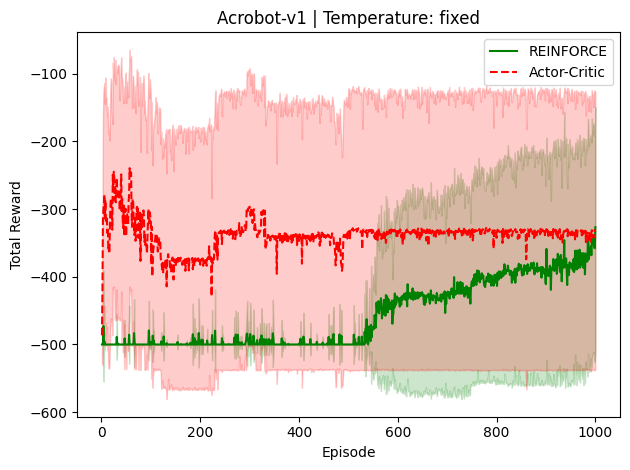

Running Acrobot-v1 | Temperature config: decreasing


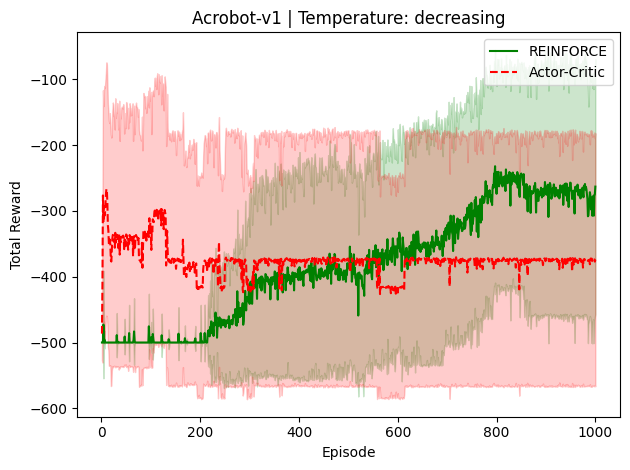

In [16]:
env_name = "Acrobot-v1"
results = run_experiment_env(env_name, temp_configs, num_episodes, gamma, lr_policy, lr_value, num_seeds, num_layers, hidden_dim, device, results)

Running ALE/Assault-ram-v5 | Temperature config: fixed


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


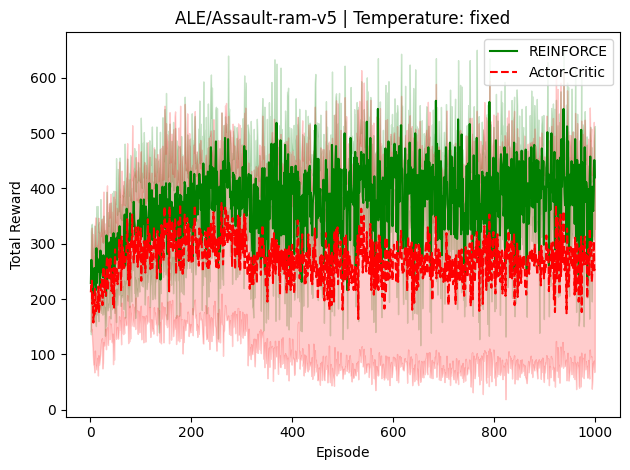

Running ALE/Assault-ram-v5 | Temperature config: decreasing


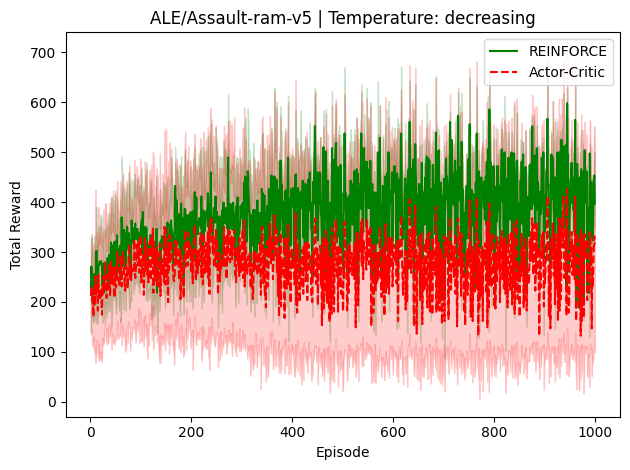

In [5]:
env_name = "ALE/Assault-ram-v5"
results = run_experiment_env(env_name, temp_configs, num_episodes, gamma, lr_policy, lr_value, num_seeds, num_layers, hidden_dim, device, results)